In [1]:
!pip install cpi
!pip install sklearn
!pip install statsmodels
!pip install price_parser
!pip install forex_python
!pip install mysql-connector-python

  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
     

In [76]:
#Basic imports
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import mysql.connector
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as tsa

from scipy import stats
from ast import literal_eval
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Custom imports
import cpi #to handle inflation
import price_parser #to handle currencies
import forex_python.converter as converter #to handle currency exchanges

# I. Preprocessing

## 1.1 Fetch data from original dataset

### Movies

In [3]:
COLUMNS_NAMES_MOVIES = [
    "freebase_id",
    "movie_name",
    "movie_release_date",
    "freebase_box_office_revenue",
    "freebase_runtime",
    "freebase_languages",
    "freebase_countries",
    "freebase_genres"
]

MOVIE_DATA = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=COLUMNS_NAMES_MOVIES, index_col=0)
MOVIE_DATA.drop(columns=["freebase_id"], inplace = True)
MOVIE_DATA = MOVIE_DATA.replace('NULL', np.NaN)
MOVIE_DATA["movie_release_date"] = pd.to_datetime(MOVIE_DATA["movie_release_date"], errors="coerce")
MOVIE_DATA["movie_release_year"] = MOVIE_DATA["movie_release_date"].dt.year.astype(int, errors="ignore")
MOVIE_DATA.dropna(subset=["movie_release_year"], inplace=True)

MOVIE_DATA.head()

,movie_name,movie_release_date,freebase_box_office_revenue,freebase_runtime,freebase_languages,freebase_countries,freebase_genres,movie_release_year
975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
28463795,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0
9363483,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0
261236,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0


### Characters

In [4]:
COLUMNS_NAMES_CHARACTERS = [
    "wiki_movie_id",
    "freebase_movie_id",
    "movie_release_date",
    "character_name",
    "actor_date_of_birth",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character_actor_map_id",
    "freebase_character_id",
    "freebase_actor_id"
]

CHARACTER_DATA = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=COLUMNS_NAMES_CHARACTERS)
CHARACTER_DATA.drop(columns=["freebase_movie_id", "movie_release_date"], inplace = True)
CHARACTER_DATA.dropna(subset=["wiki_movie_id", "character_name"], inplace=True)
CHARACTER_DATA["actor_date_of_birth"] = pd.to_datetime(CHARACTER_DATA["actor_date_of_birth"], errors="coerce")

CHARACTER_DATA.head()

,wiki_movie_id,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Plots

In [5]:
COLUMNS_NAMES_PLOTS = ["wiki_plot"]

PLOT_DATA = pd.read_csv('data/plot_summaries.txt', sep='\t', header=None, names=COLUMNS_NAMES_PLOTS, index_col=0)

PLOT_DATA.head()

,wiki_plot
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


### Tropes

In [6]:
COLUMNS_NAMES_TROPES = [
    "character_type",
    "object"
]

TROPES_DATA = pd.read_csv("data/tvtropes.clusters.txt", sep='\t', header=None, names=COLUMNS_NAMES_TROPES)
TROPES_DATA["character_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["char"], axis=1)
TROPES_DATA["movie_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["movie"], axis=1)
TROPES_DATA["freebase_id"] = TROPES_DATA.apply(lambda x: eval(x["object"])["id"], axis=1)
TROPES_DATA["actor_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["actor"], axis=1)
TROPES_DATA.drop(columns=["object"], axis=1, inplace=True)

TROPES_DATA.head()

,character_type,character_name,movie_name,freebase_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


## 1.2 Fetch data scraped from IMDB

In [7]:
db = mysql.connector.connect(
  host ="mysql.micro-ondes.ch",
  user ="r4d4r",
  passwd ="1MotDePasse",
  database = "ada_raw_imdb"
)
cursor = db.cursor()
cursor.execute("SELECT * FROM RAW_DATA")
DB_DATA = cursor.fetchall()

In [8]:
DATA_COLUMNS = ["imdb_id", "title", "cast", "imdb_genres", "imdb_runtimes", "imdb_countries", "imdb_languages", "imdb_box_office", "imdb_rating", "imdb_votes", "imdb_plot", "imdb_synopsis"]

DB_DATA = pd.DataFrame(map(lambda x: x[1:], DB_DATA), index=map(lambda x: x[0], DB_DATA), columns=DATA_COLUMNS)
DB_DATA = DB_DATA.replace('NULL', np.NaN)
DB_DATA.drop(columns=["title", "imdb_id", "cast"], inplace = True)

DB_DATA.head()

,imdb_genres,imdb_runtimes,imdb_countries,imdb_languages,imdb_box_office,imdb_rating,imdb_votes,imdb_plot,imdb_synopsis
975900,"['Action', 'Horror', 'Sci-Fi']",['98'],['United States'],['English'],"{'Budget': '$28,000,000 (estimated)', 'Opening...",4.9,55370,"['In 2176, a Martian police unit is sent to pi...","[""200 years in the future, Mars has been colon..."
28463795,"['Crime', 'Drama']",['83'],['Norway'],['Norwegian'],NaN,5.7,40,"['The lonely, divorced and disillusioned lawye...",NaN
261236,['Drama'],['106'],['West Germany'],['German'],NaN,6.0,591,"['Eva, an upper-class housewife, frustratingly...",NaN
10408933,"['Drama', 'Music', 'Musical', 'Romance']",['106'],['United States'],['English'],"{'Budget': '$2,000,000 (estimated)'}",6.9,2164,['This send-up of ragtime song and dance begin...,NaN
175026,"['Drama', 'Romance']",['86'],['United States'],['English'],NaN,5.4,274,"[""After years of abusing his wife, a ne'er-do-...",NaN


## 1.3 Merge imdb and freebase

In [9]:
MOVIE_DATA = MOVIE_DATA.join(DB_DATA)

### About box office

#### Parse imdb data

In [10]:
def func(row):
    if pd.isna(row):
        return np.NaN, np.NaN, np.NaN
    imdb_box_office = eval(row)
    budget = imdb_box_office["Budget"] if "Budget" in imdb_box_office.keys() else np.NaN
    cum_world_box_office = imdb_box_office["Cumulative Worldwide Gross"] if "Cumulative Worldwide Gross" in imdb_box_office.keys() else np.NaN
    weekend_US_box_office = imdb_box_office["Opening Weekend United States"] if "Opening Weekend United States" in imdb_box_office.keys() else np.NaN
    return budget, cum_world_box_office, weekend_US_box_office
        
        
MOVIE_DATA["budget"], MOVIE_DATA["cum_world_box_office"], MOVIE_DATA["weekend_US_box_office"] = zip(*MOVIE_DATA["imdb_box_office"].apply(func))            

#### Handle different currencies

In [11]:
def func(val, year):
    if pd.isna(val):
        return np.NaN
    price = price_parser.Price.fromstring(val)
    if price.currency == "$":
        return price.amount_float
    try:
        c = converter.CurrencyRates()
        date = datetime.datetime(int(year), 1, 1, 0, 0)
        return c.get_rate(price.currency, "USD", date) * price.amount_float
    except:
        return np.NaN
    
MOVIE_DATA["budget"] = MOVIE_DATA.apply(lambda x: func(x["budget"], x["movie_release_year"]), axis=1)
MOVIE_DATA["cum_world_box_office"] = MOVIE_DATA.apply(lambda x: func(x["cum_world_box_office"], x["movie_release_year"]), axis=1)
MOVIE_DATA["weekend_US_box_office"] = MOVIE_DATA.apply(lambda x: func(x["weekend_US_box_office"], x["movie_release_year"]), axis=1)

#### Compare IMDB to Freebase

In [12]:
print((np.log(MOVIE_DATA["cum_world_box_office"].dropna())-np.log(MOVIE_DATA["freebase_box_office_revenue"].dropna())).dropna().mean())
print((np.log(MOVIE_DATA["weekend_US_box_office"].dropna())-np.log(MOVIE_DATA["freebase_box_office_revenue"].dropna())).dropna().mean())

-0.13212905952193935
-2.6568221807037284


/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
MOVIE_DATA["box_office"] = MOVIE_DATA["freebase_box_office_revenue"]
MOVIE_DATA.drop(columns=["freebase_box_office_revenue", "imdb_box_office", "cum_world_box_office", "weekend_US_box_office"], inplace = True)

#### Handle inflation

In [14]:
def func(val, year):
    try:
        return cpi.inflate(val, int(year))
    except:
        np.NaN
    
MOVIE_DATA["budget_inflated"] = MOVIE_DATA.apply(lambda x: func(x["budget"], x["movie_release_year"]), axis=1)
MOVIE_DATA["box_office_inflated"] = MOVIE_DATA.apply(lambda x: func(x["box_office"], x["movie_release_year"]), axis=1)

### Handle languages

In [15]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        languages = set(eval(imdb))
    else:
        languages = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            l = val.replace("Language", "").replace("language", "").strip()
            languages.update([l])
    return languages

MOVIE_DATA["languages"] = MOVIE_DATA.apply(lambda x: func(x["freebase_languages"], x["imdb_languages"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_languages", "imdb_languages"], inplace = True)

### Handle countries

In [16]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        countries = set(eval(imdb))
    else:
        countries = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            c = val.replace("of America", "").strip()
            countries.update([c])
    return countries

MOVIE_DATA["countries"] = MOVIE_DATA.apply(lambda x: func(x["freebase_countries"], x["imdb_countries"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_countries", "imdb_countries"], inplace = True)

### Handle genres

In [17]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        genres = set(eval(imdb))
    else:
        genres = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            g = val.strip()
            genres.update([g])
    return genres

MOVIE_DATA["genres"] = MOVIE_DATA.apply(lambda x: func(x["freebase_genres"], x["imdb_genres"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_genres", "imdb_genres"], inplace = True)
MOVIE_DATA.drop(MOVIE_DATA[MOVIE_DATA["genres"].map(lambda x: "Short Film" in x)].index, inplace=True)

### Handle runtime

In [18]:
def func(freebase, imdb):
    if not isinstance(imdb, str):
        return freebase if not np.isnan(freebase) else np.NaN
    imdb = eval(imdb)
    if not freebase:
        return float(imdb[0])
    if freebase in imdb:
        return freebase   
    return float(imdb[0])

MOVIE_DATA["runtime"] = MOVIE_DATA.apply(lambda x: func(x["freebase_runtime"], x["imdb_runtimes"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_runtime", "imdb_runtimes"], inplace = True)
MOVIE_DATA[MOVIE_DATA["runtime"] > 360] = np.NaN

### Change column datatypes

In [19]:
def func(val):
    if isinstance(val, str):
        return set(eval(val))
    else:
        return np.NaN

MOVIE_DATA["imdb_plot"] = MOVIE_DATA["imdb_plot"].apply(func)
MOVIE_DATA["imdb_synopsis"] = MOVIE_DATA["imdb_synopsis"].apply(func)

### Add wikipedia plots

In [20]:
MOVIE_DATA = MOVIE_DATA.join(PLOT_DATA, how="left")

### Find main characters

In [21]:
def func(i, imdb_plot, imdb_synopsis, wiki_plot):
    characters = CHARACTER_DATA[CHARACTER_DATA["wiki_movie_id"] == i]
    if characters.shape[0] == 0:
        return []
    bigplot = ""
    if isinstance(imdb_plot, set):
        bigplot = bigplot + " " + " ".join(imdb_plot)
    if isinstance(imdb_synopsis, set):
        bigplot = bigplot + " " + " ".join(imdb_synopsis)
    if isinstance(wiki_plot, str):
        bigplot = bigplot + wiki_plot
    if bigplot == "":
        return []
    bigplot = bigplot.casefold()
    occurences = []
    for c, character in characters.iterrows():
        localcount = 0
        for c_part in character["character_name"].casefold().split():
            localcount += bigplot.count(c_part.strip())
        occurences.append(localcount)
    if max(occurences) == 0:
        return []
    return list(characters.iloc[[idx for idx, val in enumerate(occurences) if val == max(occurences)]]["freebase_character_actor_map_id"])

MOVIE_DATA["main_characters"] = MOVIE_DATA.apply(lambda x: func(x.name, x["imdb_plot"], x["imdb_synopsis"], x["wiki_plot"]), axis=1)

### Add tropes to characters

In [22]:
CHARACTER_DATA = CHARACTER_DATA.join(TROPES_DATA.set_index(["character_name", "actor_name"]), on=["character_name", "actor_name"])
CHARACTER_DATA.head()

,wiki_movie_id,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,character_type,movie_name,freebase_id
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,NaN,NaN
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,NaN,NaN
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,NaN,NaN,NaN
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,NaN,NaN
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,NaN,NaN


In [23]:
TROPES_DATA.head()

,character_type,character_name,movie_name,freebase_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


### Rearrange columns

In [24]:
COLUMNS_NAMES_MOVIES = ["movie_name", "movie_release_date", "movie_release_year", "runtime", "imdb_rating", "imdb_votes", "languages", "countries", "genres", "budget", "budget_inflated", "box_office", "box_office_inflated", "imdb_plot", "imdb_synopsis", "wiki_plot", "main_characters"]
MOVIE_DATA = MOVIE_DATA[COLUMNS_NAMES_MOVIES]
MOVIE_DATA.head()

,movie_name,movie_release_date,movie_release_year,runtime,imdb_rating,imdb_votes,languages,countries,genres,budget,budget_inflated,box_office,box_office_inflated,imdb_plot,imdb_synopsis,wiki_plot,main_characters
975900,Ghosts of Mars,2001-08-24,2001.0,98.0,4.9,55370.0,{English},{United States},"{Space western, Horror, Thriller, Supernatural...",28000000.0,4.284111e+07,14010832.0,2.143713e+07,"{Set 200 years in the future, intergalactic co...","{200 years in the future, Mars has been coloni...","Set in the second half of the 22nd century, th...",[/m/0jys3m]
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,2000.0,95.0,NaN,NaN,{English},{United States},"{Crime Drama, Biographical film, Mystery, Drama}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
28463795,Brun bitter,1988-01-01,1988.0,83.0,5.7,40.0,{Norwegian},{Norway},"{Crime Fiction, Crime, Drama}",NaN,NaN,NaN,NaN,"{The lonely, divorced and disillusioned lawyer...",NaN,NaN,[]
9363483,White Of The Eye,1987-01-01,1987.0,110.0,NaN,NaN,{English},{United Kingdom},"{Psychological thriller, Erotic thriller, Thri...",NaN,NaN,NaN,NaN,NaN,NaN,A series of murders of rich young women throug...,[]
261236,A Woman in Flames,1983-01-01,1983.0,106.0,6.0,591.0,{German},"{Germany, West Germany}",{Drama},NaN,NaN,NaN,NaN,"{Eva, an upper-class housewife, frustratingly ...",NaN,"Eva, an upper class housewife, becomes frustra...",[]


## 1.4 Dump to csv

In [25]:
MOVIE_DATA["genres"] = MOVIE_DATA.genres.apply(lambda x: list(x) if isinstance(x, set) else [])
MOVIE_DATA["languages"] = MOVIE_DATA.languages.apply(lambda x: list(x) if isinstance(x, set) else [])
MOVIE_DATA["countries"] = MOVIE_DATA.countries.apply(lambda x: list(x) if isinstance(x, set) else [])

In [26]:
#Export joined and cleaned data to csv
MOVIE_DATA.to_csv("data/movie_processed.csv")

/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


# II. Insights of the data

In [190]:
df_movies = pd.read_csv("data/movie_processed.csv", index_col=0)

In [191]:
# Color palette
DARK_BLUE_COLOR = "#0367A6"
LIGHT_BLUE_COLOR = "#A7D5F2"
SKY_BLUE_COLOR = "#D8E8F2"
ORANGE_COLOR = "#F2A172"
DARK_PINK_COLOR = "#F27D72"
LIGHT_PINK_COLOR = "#F2D8D8"
WHITE_COLOR = "#FFFFFF"
ORANGE_SHADE_COLOR = ["#ec722c", "#ee8243", "#f0915b", "#f2a172", "#f4b189", "#f6c0a1", "#f8d0b8"]
DARK_BLUE_SHADE_COLOR = ["#0367a6", "#1c76ae", "#3585b7", "#4e94c0", "#67a3c9", "#81b3d2", "#9ac2db", "#b3d1e4", "#cce0ed", "#e5eff6"]
PURPLE_SHADE_COLOR = ["#877df0", "#938af1", "#9f97f3", "#aba4f4", "#b7b1f6", "#c3bef7", "#cfcbf9", "#dbd8fa", "#e7e5fc", "#f3f2fd"]

ALPHA_ACTOR_GENDER = 0.75

# img path
IMG_PATH = "img/"

## 2.1 Movie production evolution

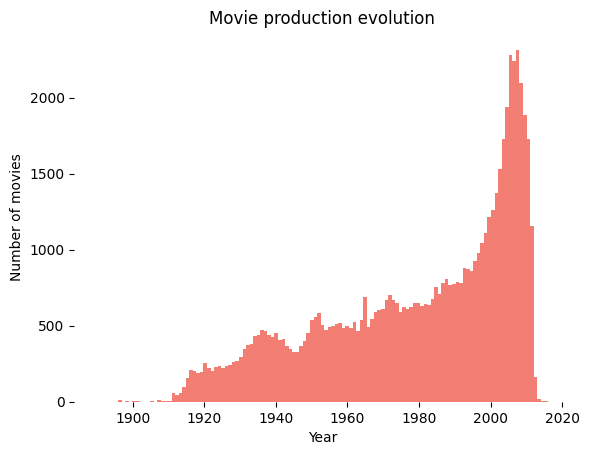

In [192]:
fig, ax = plt.subplots()

ax.hist(df_movies["movie_release_year"], bins=int(max(df_movies["movie_release_year"]) - min(df_movies["movie_release_year"]) + 1), color=DARK_PINK_COLOR)
ax.set_xlabel("Year")
ax.set_ylabel("Number of movies")
ax.set_title("Movie production evolution")
plt.box(False)
plt.savefig(IMG_PATH + "movie_production_evolution.png", bbox_inches="tight")
plt.show()

##  2.2 Number of movies per country

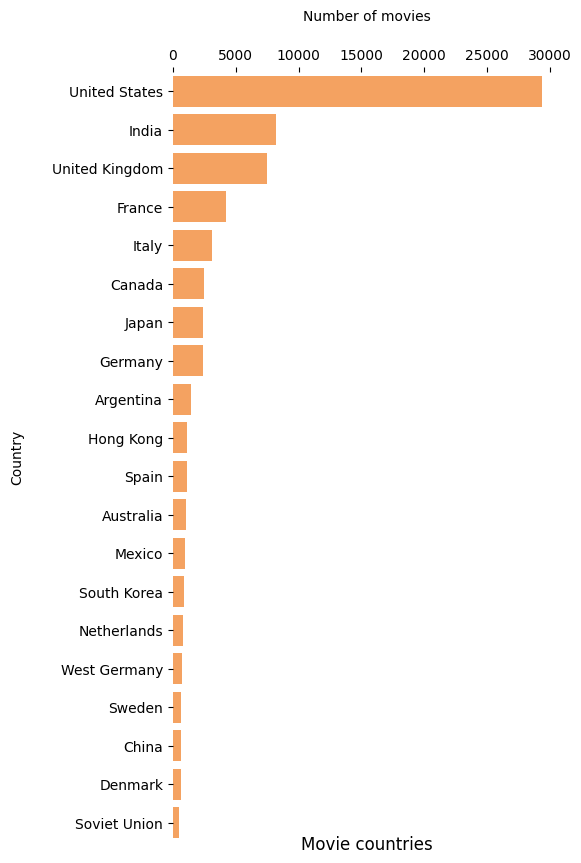

In [193]:
country_data = df_movies["countries"].apply(literal_eval).explode().value_counts()[:20].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(5,10))
ax.barh(country_data.index, np.array(country_data.values), color="#f4a261")
ax.set_ylabel("Country")
ax.set_xlabel("Number of movies")
ax.set_title("Movie countries", y = -0.02)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.ylim([-0.5,country_data.size-0.5])
plt.box(False)
plt.savefig(IMG_PATH + "movie_countries.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

The plot of the number of movies depending of their country of origin shows clearly that the USA dominates the movie industry. The rest of the world is far behind. The second country is India, followed by UK and France.

In [194]:
prop_usa_prod_global = country_data["United States"] / country_data.sum()
prop_usa_prod_second = country_data["United States"] / country_data["India"]

print("Proportion of movies produced in the USA: {:.2f}%".format(prop_usa_prod_global * 100))
print("The USA procuduces {:.2f} times more movies than India, the second movie productucor.".format(prop_usa_prod_second))

Proportion of movies produced in the USA: 41.91%
The USA procuduces 3.58 times more movies than India, the second movie productucor.


## 2.3 Number of movies per language

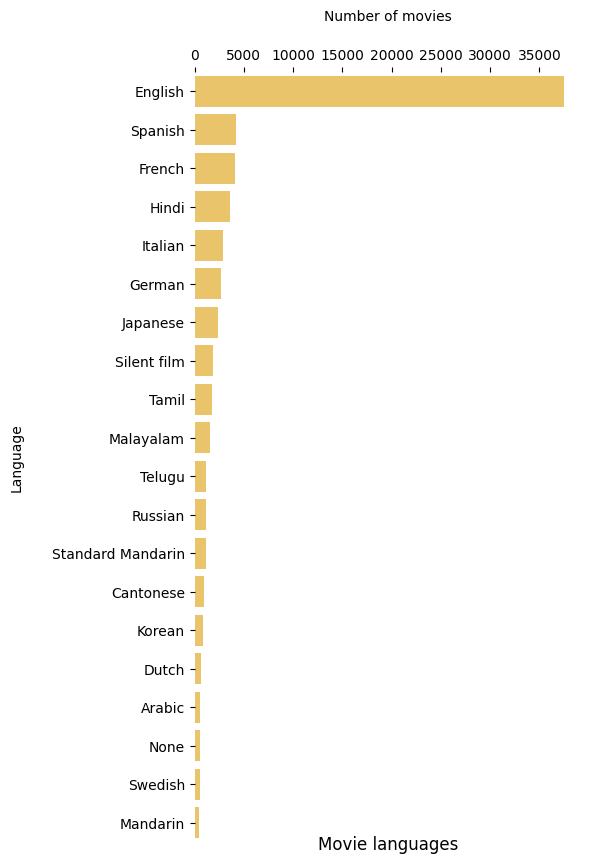

In [195]:
language_data = df_movies["languages"].apply(literal_eval).explode().value_counts()[:20].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(5,10))
ax.barh(language_data.index, np.array(language_data.values), color="#e9c46a")
ax.set_ylabel("Language")
ax.set_xlabel("Number of movies")
ax.set_title("Movie languages", y = -0.02)
plt.ylim([-0.5, language_data.size-0.5])
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.box(False)
plt.savefig(IMG_PATH + "movie_languages.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

This plot shows that the most common languages are English, French, Spanish, German and Italian, english being by far the most common language.

In [196]:
prop_english_movies_global = language_data["English"] / language_data.sum()
prop_english_movies_second = language_data["English"] / language_data["Spanish"]

print("Proportion of movies in English: {:.2f}%".format(prop_english_movies_global * 100))
print("The English language is used in {:.2f} times more movies than Spanish, the second most used language.".format(prop_english_movies_second))

Proportion of movies in English: 53.26%
The English language is used in 8.89 times more movies than Spanish, the second most used language.


## 2.4 Number of movies per genre

In [197]:
genre_data = df_movies["genres"].apply(literal_eval).explode().value_counts()[:20]

#Merge "Romantic Film" and "Romance" genres
genre_data["Romance"] += genre_data["Romance Film"]
genre_data = genre_data.drop("Romance Film")

#Split Action/Adventure
genre_data["Action"] += genre_data["Action/Adventure"]
genre_data["Adventure"] += genre_data["Action/Adventure"]
genre_data = genre_data.drop("Action/Adventure")

genre_data = genre_data.sort_values(ascending=True)

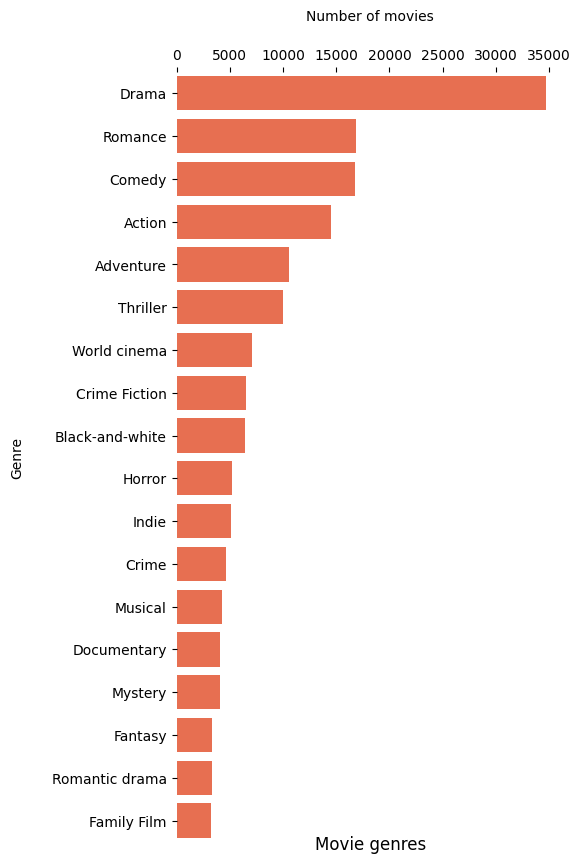

In [198]:
fig, ax = plt.subplots(figsize=(5,10))
ax.barh(genre_data.index, np.array(genre_data.values), color="#e76f51")
ax.set_ylabel("Genre")
ax.set_xlabel("Number of movies")
ax.set_title("Movie genres", y = -0.02)
plt.ylim([-0.5, genre_data.size-0.5])
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.box(False)
plt.savefig(IMG_PATH + "movie_genres.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [199]:
prop_main_genre_global = (genre_data["Drama"] + genre_data["Romance"] + genre_data["Comedy"] + genre_data["Action"] + genre_data["Adventure"] + genre_data["Thriller"]) / genre_data.sum()

print("Proportion of movies in the main genres: {:.2f}%".format(prop_main_genre_global * 100))

Proportion of movies in the main genres: 64.30%


This plot shows that the most common genres are Drama, Romance, Comedy, Action, Adventure and Thriller.
Those 6 genres represent almost two thirds of the movies in the dataset.

# III. Analysis of movie production evolution

## 3.1 Runtime analysis

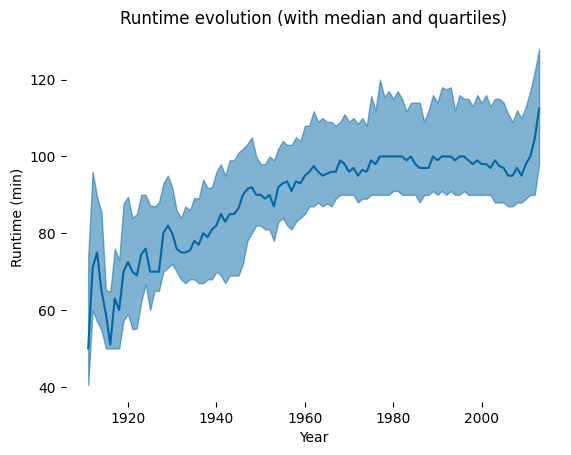

In [200]:
df_runtime = df_movies[["movie_release_year", "runtime"]]
des_runtime = df_runtime.groupby("movie_release_year").describe()["runtime"]
des_runtime = des_runtime[des_runtime["count"] >= 5]

plt.fill_between(des_runtime.index, des_runtime["25%"].values, des_runtime["75%"].values, alpha = 0.5, color = DARK_BLUE_COLOR)
plt.plot(des_runtime.index, des_runtime["50%"], color = DARK_BLUE_COLOR)
plt.xlabel('Year')
plt.ylabel('Runtime (min)')
plt.title('Runtime evolution (with median and quartiles)')
plt.box(False)
plt.savefig(IMG_PATH+"runtime_evolution.png")
plt.show()

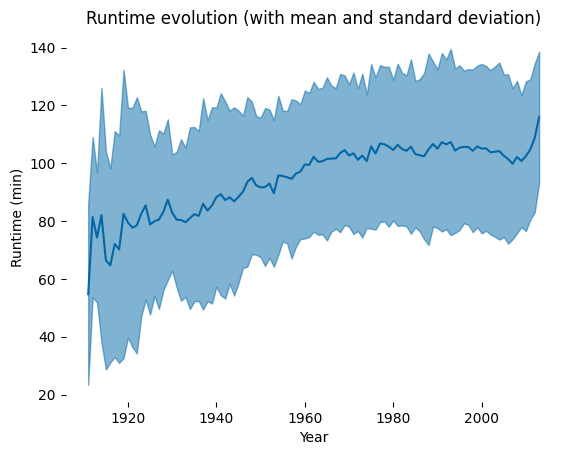

In [201]:
plt.fill_between(des_runtime.index, des_runtime["mean"].values - des_runtime["std"].values, des_runtime["mean"].values + des_runtime["std"].values, alpha = 0.5, color = DARK_BLUE_COLOR)
plt.plot(des_runtime["mean"], color = DARK_BLUE_COLOR)
plt.xlabel('Year')
plt.ylabel('Runtime (min)')
plt.title('Runtime evolution (with mean and standard deviation)')
plt.box(False)
plt.savefig(IMG_PATH+"runtime_evolution_std.png")
plt.show()

There seems to be a correlation between the runtime and the year of production. The runtime is increasing with the year of production.

## 3.2 Genres analysis

In [202]:
df_genre = []
movie_norm_factor = df_movies["movie_release_year"].value_counts()
for year in movie_norm_factor.index:
    row = []
    for genre in genre_data.index:
        matched = df_movies[df_movies["movie_release_year"] == year]
        matched = matched[matched["genres"].apply(lambda x: genre in x)]
        if len(matched):
            row.append(matched.count()["genres"])
        else:
            row.append(0)
    row = np.asarray(row) / movie_norm_factor[year]
    df_genre.append(row)
df_genre = pd.DataFrame(df_genre, index = movie_norm_factor.index, columns=genre_data.index).sort_index()

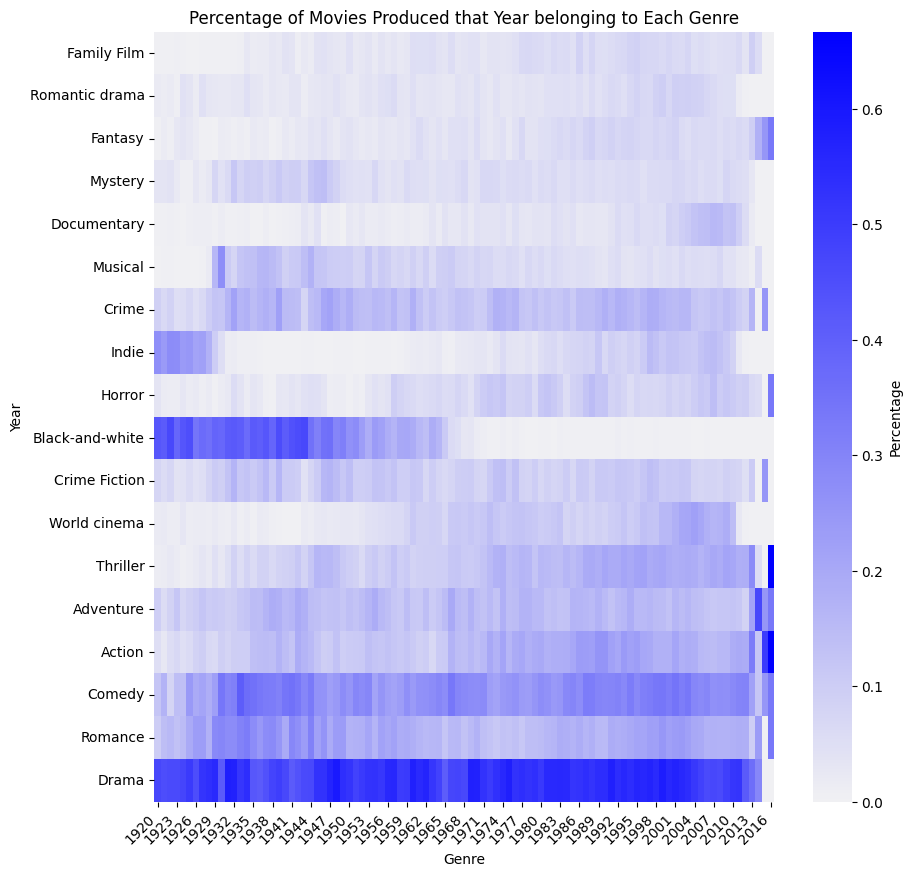

In [293]:
df_genre.index = df_genre.index.astype(int)
df_genre_newer = df_genre[df_genre.index > 1919].T


plt.figure(figsize=(10,10))
sns.heatmap(df_genre_newer, cbar_kws={'label': 'Percentage'}, cmap = sns.color_palette("light:b", as_cmap=True))
plt.xlabel('Genre')
plt.ylabel('Year')
plt.xticks(rotation=45, ha='right')
plt.title("Percentage of Movies Produced that Year belonging to Each Genre")
plt.savefig(IMG_PATH+"genre_evolution.png")
plt.show()

## 3.3 Main character analysis

In [204]:
df_character = df_movies[["movie_release_year", "genres", "main_characters"]].copy()
df_character["genres"] = df_character.genres.apply(literal_eval)
df_character["main_characters"] = df_character.main_characters.apply(literal_eval)
df_character = df_character.explode("main_characters").dropna()

df_character = df_character.join(CHARACTER_DATA.set_index("freebase_character_actor_map_id")[["actor_gender", "actor_height", "actor_age_at_movie_release"]], on="main_characters")
df_character.head()

,movie_release_year,genres,main_characters,actor_gender,actor_height,actor_age_at_movie_release
975900,2001.0,"[Space western, Horror, Thriller, Supernatural...",/m/0jys3m,F,1.780,27.0
18998739,2002.0,"[Fantasy, Adventure, Family Film, World cinema]",/m/04lrj09,F,1.727,41.0
10408933,1938.0,"[Comedy, Music, Musical, Black-and-white, Roma...",/m/02vbvj2,M,1.820,24.0
6631279,1997.0,"[Comedy, Ensemble Film, Romantic drama, Romant...",/m/04hvbft,F,1.570,37.0
171005,1989.0,"[History, Costume drama, Epic, Film adaptation...",/m/02vdfck,M,1.830,15.0


### 3.3.1 Gender fraction

In [205]:
df_character_F = df_character[df_character["actor_gender"] == "F"]["movie_release_year"].value_counts().sort_index()
df_character_M = df_character[df_character["actor_gender"] == "M"]["movie_release_year"].value_counts().sort_index()

df_character_F = df_character_F[df_character_F.index]
df_character_M = df_character_M[df_character_M.index]

df_sum = df_character_F + df_character_M
df_character_F = df_character_F[df_sum > 0] / df_sum
df_character_M = df_character_M[df_sum > 0] / df_sum

index = df_character_F.index

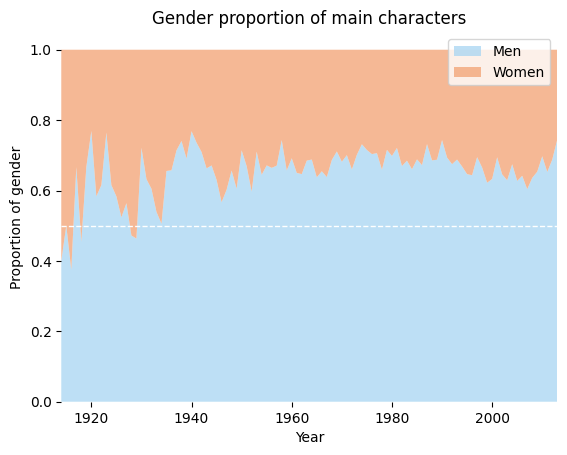

In [206]:
fig, ax = plt.subplots()
ax.stackplot(df_character_M.index, df_character_M.values, df_character_F.values, alpha=ALPHA_ACTOR_GENDER, colors=[LIGHT_BLUE_COLOR, ORANGE_COLOR], labels=["Men", "Women"])
ax.hlines(y=0.5, xmin=1914, xmax=2013, linewidth=1, color=WHITE_COLOR, linestyles='dashed') # 0.5 line
ax.set_xlim([1914, 2013])
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of gender")
ax.set_title("Gender proportion of main characters")
ax.legend()
plt.box(False)
plt.savefig(IMG_PATH+"Gender proportion of main characters.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

### 3.3.2 Age by gender

In [207]:
df_character_F_age = df_character[df_character["actor_gender"] == "F"][["movie_release_year", "actor_age_at_movie_release"]].groupby("movie_release_year").describe()["actor_age_at_movie_release"]
df_character_M_age = df_character[df_character["actor_gender"] == "M"][["movie_release_year", "actor_age_at_movie_release"]].groupby("movie_release_year").describe()["actor_age_at_movie_release"]
df_character_F_age = df_character_F_age[df_character_F_age["count"] >= 5]
df_character_M_age = df_character_M_age[df_character_M_age["count"] >= 5]

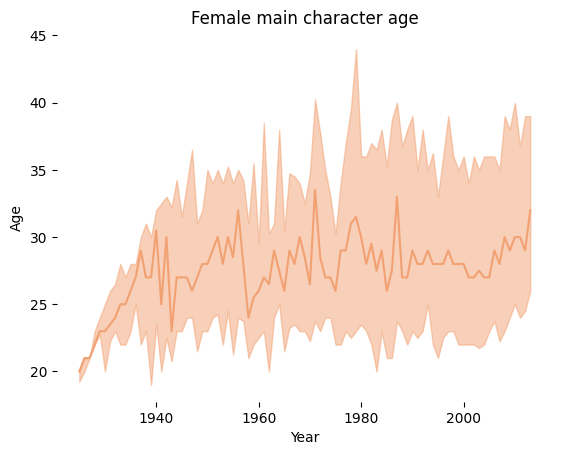

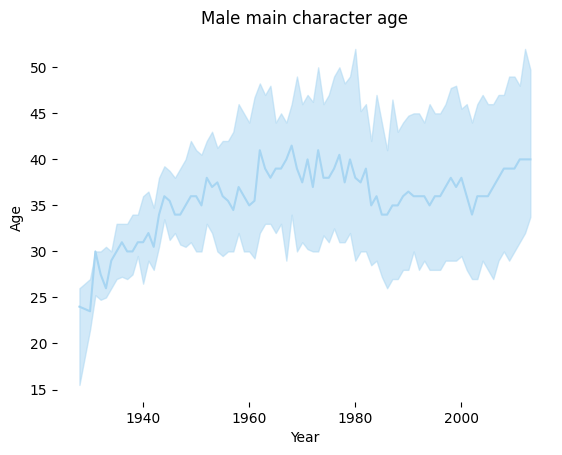

In [208]:
plt.fill_between(df_character_F_age.index, df_character_F_age["25%"].values, df_character_F_age["75%"].values, alpha = 0.5, color = ORANGE_COLOR)
plt.plot(df_character_F_age.index, df_character_F_age["50%"].values, color = ORANGE_COLOR)
plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Female main character age')
plt.box(False)
plt.savefig(IMG_PATH+"Female main charecter age.png")
plt.show()

plt.fill_between(df_character_M_age.index, df_character_M_age["25%"].values, df_character_M_age["75%"].values, alpha = 0.5, color = LIGHT_BLUE_COLOR)
plt.plot(df_character_M_age.index, df_character_M_age["50%"].values, color = LIGHT_BLUE_COLOR)
plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Male main character age')
plt.box(False)
plt.savefig(IMG_PATH+"Male main character age.png")
plt.show()

### 3.3.3 Height by gender

In [209]:
df_character_F_height = df_character[df_character["actor_gender"] == "F"][["movie_release_year", "actor_height"]].groupby("movie_release_year").describe()["actor_height"]
df_character_M_height = df_character[df_character["actor_gender"] == "M"][["movie_release_year", "actor_height"]].groupby("movie_release_year").describe()["actor_height"]
df_character_F_height = df_character_F_height[df_character_F_height["count"] >= 5]
df_character_M_height = df_character_M_height[df_character_M_height["count"] >= 5]

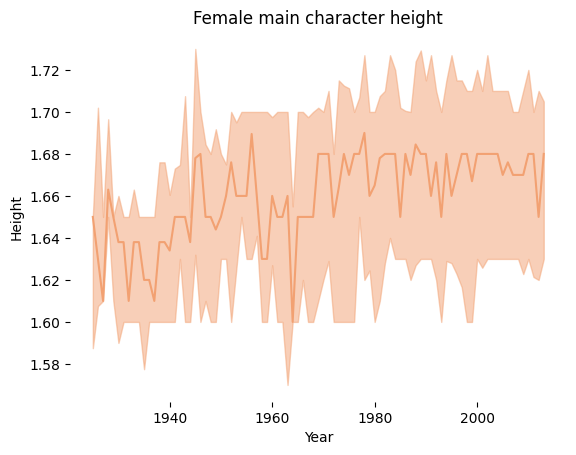

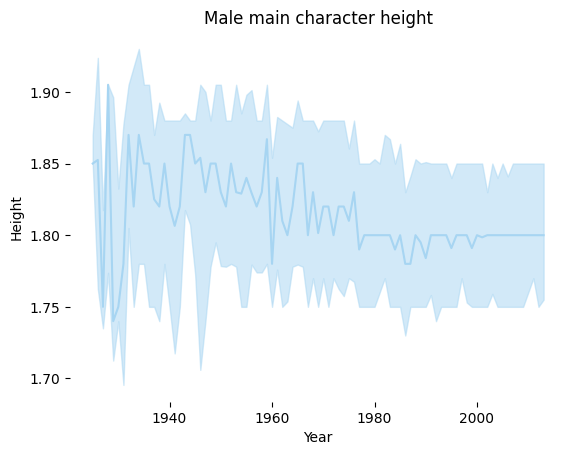

In [210]:
plt.fill_between(df_character_F_height.index, df_character_F_height["25%"].values, df_character_F_height["75%"].values, alpha = 0.5, color = ORANGE_COLOR)
plt.plot(df_character_F_height.index, df_character_F_height["50%"].values, color = ORANGE_COLOR)
plt.xlabel('Year')
plt.ylabel('Height')
plt.title('Female main character height')
plt.box(False)
plt.savefig(IMG_PATH+"Female main character height.png")
plt.show()

plt.fill_between(df_character_M_height.index, df_character_M_height["25%"].values, df_character_M_height["75%"].values, alpha = 0.5, color = LIGHT_BLUE_COLOR)
plt.plot(df_character_M_height.index, df_character_M_height["50%"].values, color = LIGHT_BLUE_COLOR)
plt.xlabel('Year')
plt.ylabel('Height')
plt.title('Male main character height')
plt.box(False)
plt.savefig(IMG_PATH+"Male main character height.png")
plt.show()

### 3.3.4 Gender proportion of the main character by genre

In [211]:
df_character["isMale"] = df_character.apply(lambda x: 1 if x["actor_gender"] == "M" else 0, axis=1)
prop_men_by_gender = df_character.explode("genres").groupby("genres").apply(lambda x: x["isMale"].mean())
props_men = prop_men_by_gender[["Drama", "Romance", "Comedy", "Action", "Adventure", "Thriller"]].sort_index()
props_women = 1 - props_men

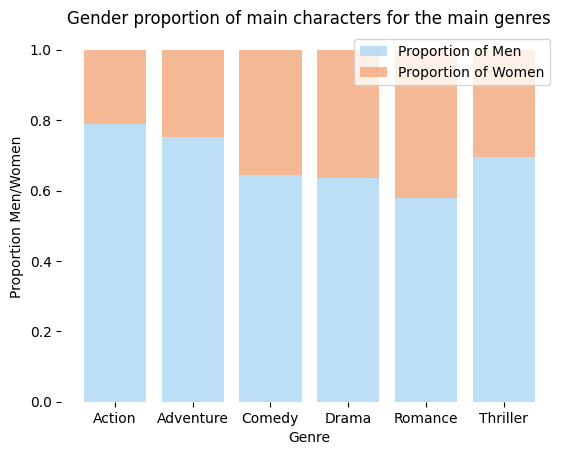

In [212]:
fig, ax = plt.subplots()
ax.bar(props_men.index, props_men.values, alpha=ALPHA_ACTOR_GENDER, color= LIGHT_BLUE_COLOR)
ax.bar(props_women.index, props_women.values, bottom=props_men.values, alpha=ALPHA_ACTOR_GENDER, color=ORANGE_COLOR)

ax.set_xlabel("Genre")
ax.set_ylabel("Proportion Men/Women")
ax.set_title("Gender proportion of main characters for the main genres")
ax.legend(["Proportion of Men", "Proportion of Women"])
plt.box(False)
plt.savefig(IMG_PATH+"Gender proportion of main characters for the main genres.png")
plt.show()

From this plot we can see that the distribution of the gender is quite depending of the gendre of the movie even though the proportion of men is higher than the proportion of women.

## 3.4 Box office analysis

In [266]:
df_box_office = df_movies[["movie_release_year", "budget", "budget_inflated", "box_office", "box_office_inflated"]]
des_box_office = df_box_office.groupby("movie_release_year").describe()
#We remove the year before 1920 as the data is very scarce and creates a huge pic in the graph, which makes it hard to read
des_box_office = des_box_office[des_box_office.index>=1920]

In [268]:
# Helper function to format the axes tick labels
def currency(x, pos):
    if x >= 1e9:
        s = '${:1.0f}B'.format(x*1e-9)
    elif x >= 1e6:
        s = '${:1.0f}M'.format(x*1e-6)
    elif x > 0:
        s = '${:1.0f}K'.format(x*1e-3)
    else:
        s = '${:1.0f}'.format(x)
    return s

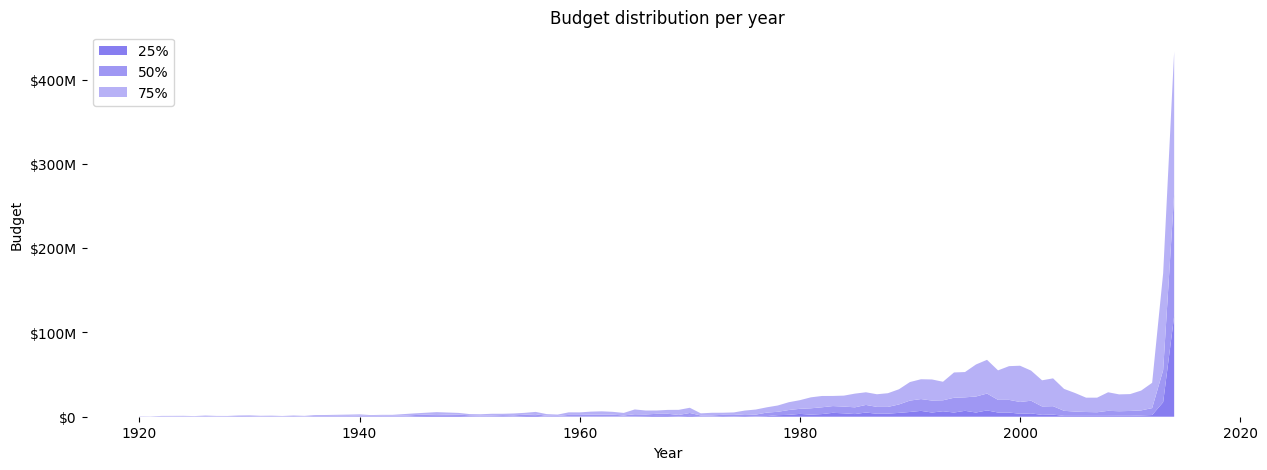

In [269]:
purple_shades = [PURPLE_SHADE_COLOR[0], PURPLE_SHADE_COLOR[2], PURPLE_SHADE_COLOR[4]]

fig, ax = plt.subplots(figsize=(15, 5))
ax.stackplot(des_box_office.index, des_box_office["budget"]["25%"], des_box_office["budget"]["50%"], des_box_office["budget"]["75%"], labels=["25%", "50%", "75%"], colors=purple_shades)
ax.set_title("Budget distribution per year")
ax.set_xlabel("Year")
ax.set_ylabel("Budget")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.box(False)
plt.savefig(IMG_PATH+"Budget distribution per year.png")
plt.show()

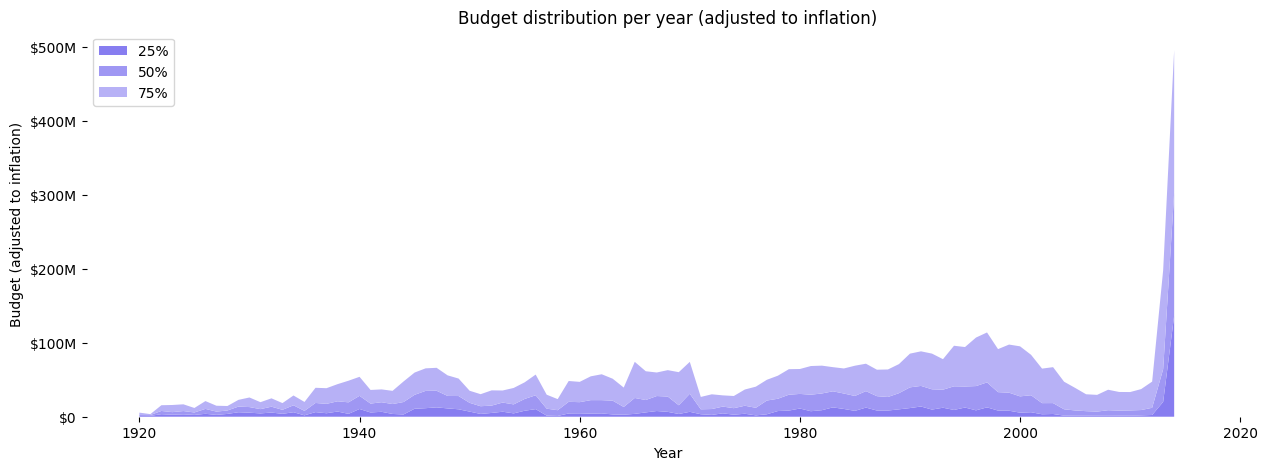

In [270]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.stackplot(des_box_office.index, des_box_office["budget_inflated"]["25%"], des_box_office["budget_inflated"]["50%"], des_box_office["budget_inflated"]["75%"], labels=["25%", "50%", "75%"], colors=purple_shades)
ax.set_title("Budget distribution per year (adjusted to inflation)")
ax.set_xlabel("Year")
ax.set_ylabel("Budget (adjusted to inflation)")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.box(False)
plt.savefig(IMG_PATH+"Budget distribution per year (adjusted to inflation).png")
plt.show()

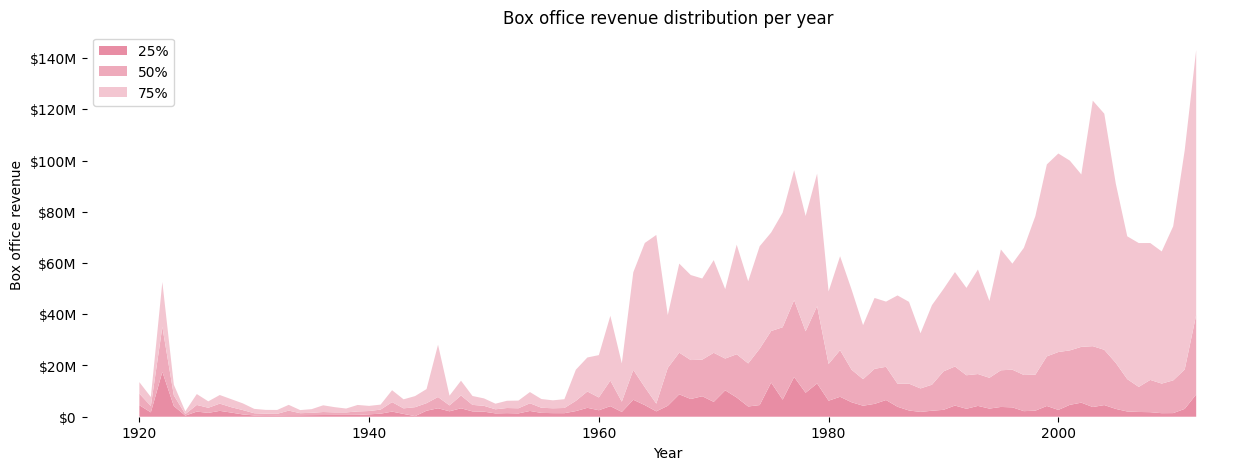

In [271]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.stackplot(des_box_office.index, des_box_office["box_office"]["25%"], des_box_office["box_office"]["50%"], des_box_office["box_office"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Box office revenue distribution per year")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.box(False)
plt.savefig(IMG_PATH+"Box office revenue distribution per year.png")
plt.show()

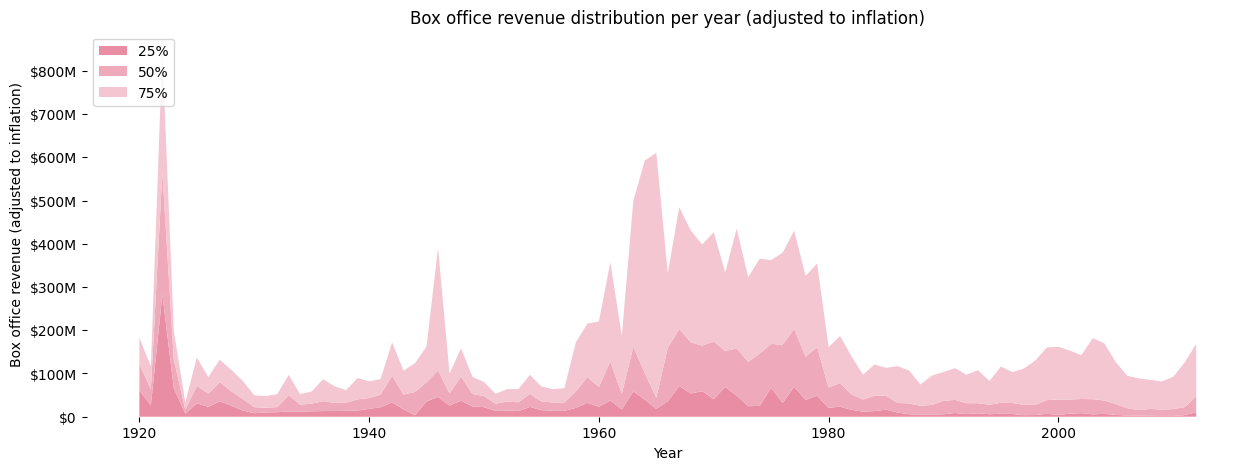

In [285]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.stackplot(des_box_office.index, des_box_office["box_office_inflated"]["25%"], des_box_office["box_office_inflated"]["50%"], des_box_office["box_office_inflated"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Box office revenue distribution per year (adjusted to inflation)")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue (adjusted to inflation)")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.box(False)
plt.savefig(IMG_PATH+"Box office revenue distribution per year (adjusted to inflation).png")
plt.show()

# 4. Testing the correlations to box office

## 4.1 Granger causality for the forecastability of the median

In [273]:
box_office_inflated = des_box_office["box_office_inflated"]["50%"]

median_M_age = df_character_M_age["50%"]
median_F_age = df_character_F_age["50%"]
median_M_height = df_character_M_height["50%"]
median_F_height = df_character_F_height["50%"]

In [274]:
def get_best_causality(results):
    best = (0, 0, 1)
    for lag in results:
        if results[lag][0]['ssr_chi2test'][1] < best[2]:
            best = (lag, *results[lag][0]['ssr_chi2test'][:2])
    return best

### Runtime

In [275]:
df_runtime = pd.concat([box_office_inflated, des_runtime["50%"]], axis=1, join="inner").dropna()
df_runtime = df_runtime[df_runtime.index > 1919]
grag_caus_runtime = get_best_causality(tsa.grangercausalitytests(df_runtime, maxlag=10, verbose = False))

(a, b, c) = grag_caus_runtime
print("The p-value is {:.2f}.".format(c))
print("The lag is {}.".format(a))
print("The null hypothesis is rejected.") if c < 0.05 else print("The null hypothesis is not rejected.")

The p-value is 0.06.
The lag is 3.
The null hypothesis is not rejected.


### Genre proportion

In [286]:
for genre in df_genre:
    df = pd.concat([box_office_inflated, df_genre[genre]], axis=1, join="inner").dropna()
    df = df[df.index > 1919]
    grag = get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False))
    print(genre, grag)
    print("The null hypothesis is rejected.") if grag[2] < 0.05 else print("The null hypothesis is not rejected.")

Family Film (6, 8.040712807696705, 0.2351357347233654)
The null hypothesis is not rejected.
Romantic drama (8, 16.361208180011268, 0.03749242295908712)
The null hypothesis is rejected.
Fantasy (4, 16.98557747948606, 0.0019454610050396984)
The null hypothesis is rejected.
Mystery (3, 3.5093419389030336, 0.31955252236037485)
The null hypothesis is not rejected.
Documentary (10, 20.230828724537698, 0.027143497909652793)
The null hypothesis is rejected.
Musical (3, 6.475382109041633, 0.09063844508941032)
The null hypothesis is not rejected.
Crime (10, 17.410421328523157, 0.06576154185340033)
The null hypothesis is not rejected.
Indie (3, 20.483530322903952, 0.00013475076397202548)
The null hypothesis is rejected.
Horror (9, 11.154413435032728, 0.2652730540095207)
The null hypothesis is not rejected.
Black-and-white (3, 12.198542841492406, 0.006733078531532775)
The null hypothesis is rejected.
Crime Fiction (1, 1.53116518776649, 0.21593765504278056)
The null hypothesis is not rejected.
Worl

### Main character gender

In [277]:
df_gender = pd.concat([box_office_inflated, df_character_F], axis=1, join="inner").dropna()
df_gender = df_gender[df_gender.index > 1919]
grag_caus_gender = get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False))

(a, b, c) = grag_caus_gender
print("The p-value is {:.2f}.".format(c))
print("The lag is {}.".format(a))
print("The null hypothesis is rejected.") if c < 0.05 else print("The null hypothesis is not rejected.")

The p-value is 0.42.
The lag is 6.
The null hypothesis is not rejected.


### Main character age

In [278]:
df_F_age = pd.concat([box_office_inflated, median_F_age], axis=1, join="inner").dropna()
df_M_age = pd.concat([box_office_inflated, median_M_age], axis=1, join="inner").dropna()
df_F_age = df_F_age[df_F_age.index > 1919]
df_M_age = df_M_age[df_M_age.index > 1919]
grag_caus_F = get_best_causality(tsa.grangercausalitytests(df_F_age, maxlag=10, verbose = False))
grag_caus_M = get_best_causality(tsa.grangercausalitytests(df_M_age, maxlag=10, verbose = False))

(a, b, c) = grag_caus_F
print("The p-value is {:.2f}.".format(c))
print("The lag is {}.".format(a))
print("The null hypothesis is rejected.") if c < 0.05 else print("The null hypothesis is not rejected.")
(a, b, c) = grag_caus_M
print("The p-value is {:.2f}.".format(c))
print("The lag is {}.".format(a))
print("The null hypothesis is rejected.") if c < 0.05 else print("The null hypothesis is not rejected.")

The p-value is 0.03.
The lag is 9.
The null hypothesis is rejected.
The p-value is 0.02.
The lag is 10.
The null hypothesis is rejected.


### Main character height

In [279]:
df_F_height = pd.concat([box_office_inflated, median_F_height], axis=1, join="inner").dropna()
df_M_height = pd.concat([box_office_inflated, median_M_height], axis=1, join="inner").dropna()
df_F_height = df_F_height[df_F_height.index > 1919]
df_M_height = df_M_height[df_M_height.index > 1919]
grag_caus_F = get_best_causality(tsa.grangercausalitytests(df_F_height, maxlag=10, verbose = False))
grag_caus_M = get_best_causality(tsa.grangercausalitytests(df_M_height, maxlag=10, verbose = False))

(a, b, c) = grag_caus_F
print("The p-value is {:.2f}.".format(c))
print("The lag is {}.".format(a))
print("The null hypothesis is rejected.") if c < 0.05 else print("The null hypothesis is not rejected.")
(a, b, c) = grag_caus_M
print("The p-value is {:.2f}.".format(c))
print("The lag is {}.".format(a))
print("The null hypothesis is rejected.") if c < 0.05 else print("The null hypothesis is not rejected.")

The p-value is 0.00.
The lag is 9.
The null hypothesis is rejected.
The p-value is 0.01.
The lag is 8.
The null hypothesis is rejected.


## 4.2 Pearson correlation on the last 30 years

In [280]:
df_movies_treated = df_movies[df_movies["movie_release_year"] > 1979]
df_movies_treated = df_movies[df_movies["movie_release_year"] < 2010]

### Runtime

In [281]:
df = df_movies[["box_office_inflated","runtime","imdb_rating"]].dropna()
for column in df:
    df[column] = (df[column] - df[column].mean()) / df[column].std()
res = stats.pearsonr(df["box_office_inflated"], df["runtime"])
print(res)
res = stats.pearsonr(df["imdb_rating"], df["runtime"])
print(res)

PearsonRResult(statistic=0.24619430951446647, pvalue=5.004706081597913e-85)
PearsonRResult(statistic=0.36612362606365173, pvalue=3.8422279346632283e-193)


### Genre proportion

In [282]:
df = df_movies[["box_office_inflated","genres","imdb_rating"]].dropna()
df["box_office_inflated"] = (df["box_office_inflated"] - df["box_office_inflated"].mean()) / df["box_office_inflated"].std()
df["imdb_rating"] = (df["imdb_rating"] - df["imdb_rating"].mean()) / df["imdb_rating"].std()
for genre in df_genre:
    df["genre_bool"] = df.apply(lambda x: int(genre in x["genres"]), axis=1)
    df["genre_bool"] = (df["genre_bool"] - df["genre_bool"].mean()) / df["genre_bool"].std()
    res1 = stats.pearsonr(df["box_office_inflated"], df["genre_bool"])
    res2 = stats.pearsonr(df["imdb_rating"], df["genre_bool"])
    print(genre, res1, res2)

Family Film PearsonRResult(statistic=0.14135906967068415, pvalue=1.2120021748534218e-28) PearsonRResult(statistic=-0.06946730029745639, pvalue=5.4651931788304493e-08)
Romantic drama PearsonRResult(statistic=-0.0011125059357184773, pvalue=0.930716885389034) PearsonRResult(statistic=0.07438168563518609, pvalue=5.848600866525013e-09)
Fantasy PearsonRResult(statistic=0.12425241348338388, pvalue=1.8779785146550347e-22) PearsonRResult(statistic=-0.08106678844301428, pvalue=2.2119222896621658e-10)
Mystery PearsonRResult(statistic=0.00458656624463721, pvalue=0.7200108354364575) PearsonRResult(statistic=0.035374651744877694, pvalue=0.005685093456116222)
Documentary PearsonRResult(statistic=-0.034129632969360675, pvalue=0.007629858762890787) PearsonRResult(statistic=0.11097355407547616, pvalue=3.3329258719560204e-18)
Musical PearsonRResult(statistic=0.02820052170521536, pvalue=0.027501627883861155) PearsonRResult(statistic=0.00891347736685368, pvalue=0.4860490782096858)
Crime PearsonRResult(stat

### Main character gender

In [294]:
df = df_movies[["box_office_inflated","main_characters","imdb_rating"]].dropna()
df = df[df.apply(lambda x: len(x["main_characters"])>0, axis=1)]
df["M"] = 0
df["F"] = 0
df["Mage"] = 0
df["Fage"] = 0
df["Mheight"] = 0
df["Fheight"] = 0
for i, row in df.iterrows():
    toadd = [0,0,0,0,0,0]
    for c in row["main_characters"]:
        data = CHARACTER_DATA[CHARACTER_DATA["freebase_character_actor_map_id"] == c]
        if data["actor_gender"].values == "F":
            toadd[1] += 1
            toadd[3] += data["actor_age_at_movie_release"].values
            toadd[5] += data["actor_height"].values
        if data["actor_gender"].values == "M":
            toadd[0] += 1
            toadd[2] += data["actor_age_at_movie_release"].values
            toadd[4] += data["actor_height"].values
    for j in range(2):
        if toadd[j] > 1:
            toadd[j+2] /= toadd[j]
            toadd[j+4] /= toadd[j]
            toadd[j] /= toadd[j]
    row["M"],row["F"],row["Mage"],row["Fage"],row["Mheight"],row["Fheight"]  = tuple(toadd)
    df.loc[i] = row
df.drop(columns=["main_characters"], inplace = True)

/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_48946/756085314.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if data["actor_gender"].values == "F":
/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_48946/756085314.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if data["actor_gender"].values == "M":


In [295]:
res1 = stats.pearsonr(df["box_office_inflated"], df["M"])
res2 = stats.pearsonr(df["imdb_rating"], df["M"])
print(res1, res2)
res1 = stats.pearsonr(df["box_office_inflated"], df["F"])
res2 = stats.pearsonr(df["imdb_rating"], df["F"])
print(res1, res2)

PearsonRResult(statistic=nan, pvalue=nan) PearsonRResult(statistic=nan, pvalue=nan)
PearsonRResult(statistic=nan, pvalue=nan) PearsonRResult(statistic=nan, pvalue=nan)


/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [296]:
df2 = df[["box_office_inflated", "Mage", "imdb_rating"]].dropna()
res1 = stats.pearsonr(df2["box_office_inflated"], df2["Mage"])
res2 = stats.pearsonr(df2["imdb_rating"], df2["Mage"])
print(res1, res2)
df2 = df[["box_office_inflated", "Fage", "imdb_rating"]].dropna()
res1 = stats.pearsonr(df2["box_office_inflated"], df2["Fage"])
res2 = stats.pearsonr(df2["imdb_rating"], df2["Fage"])
print(res1, res2)

PearsonRResult(statistic=nan, pvalue=nan) PearsonRResult(statistic=nan, pvalue=nan)
PearsonRResult(statistic=nan, pvalue=nan) PearsonRResult(statistic=nan, pvalue=nan)


/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [297]:
df2 = df[["box_office_inflated", "Mheight", "imdb_rating"]].dropna()
res1 = stats.pearsonr(df2["box_office_inflated"], df2["Mheight"])
res2 = stats.pearsonr(df2["imdb_rating"], df2["Mheight"])
print(res1, res2)
df2 = df[["box_office_inflated", "Fheight", "imdb_rating"]].dropna()
res1 = stats.pearsonr(df2["box_office_inflated"], df2["Fheight"])
res2 = stats.pearsonr(df2["imdb_rating"], df2["Fheight"])
print(res1, res2)

PearsonRResult(statistic=nan, pvalue=nan) PearsonRResult(statistic=nan, pvalue=nan)
PearsonRResult(statistic=nan, pvalue=nan) PearsonRResult(statistic=nan, pvalue=nan)


/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


# 5. Trying to predict box office

In [298]:
predict_data = df_movies[["movie_release_year","box_office_inflated","imdb_rating","budget_inflated","runtime","genres"]]
predict_data = predict_data.join(df[["M","F","Mage","Fage","Mheight","Fheight"]])
for genre in df_genre:
    predict_data[genre] = predict_data.apply(lambda x: int(genre in x["genres"]), axis=1)
predict_data.drop(columns=["genres"], inplace=True)
predict_data = predict_data.dropna()
predict_data.head()

,movie_release_year,box_office_inflated,imdb_rating,budget_inflated,runtime,M,F,Mage,Fage,Mheight,...,Horror,Black-and-white,Crime Fiction,World cinema,Thriller,Adventure,Action,Comedy,Romance,Drama
975900,2001.0,2.143713e+07,4.9,4.284111e+07,98.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,1,0,0,0
10408933,1938.0,6.918383e+07,6.9,3.843546e+07,106.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,1,1,1
171005,1989.0,2.220446e+07,7.5,1.966718e+07,137.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
77856,1964.0,8.939626e+08,7.8,5.244581e+07,139.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
156558,2001.0,4.495508e+07,6.4,2.448063e+07,130.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,1,1


In [299]:
X = predict_data[["budget_inflated","runtime","M","F","Mage","Fage","Mheight","Fheight","Family Film","Romantic drama","Fantasy","Mystery","Documentary","Musical","Crime","Indie","Horror","Adventure","Black-and-white","Crime Fiction","World cinema","Romance","Action","Thriller","Comedy","Drama"]]
y = predict_data["box_office_inflated"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 
reg = LinearRegression()
reg.fit(X_train, y_train)
print(np.dot(y.values,y.values)**(1/len(y.values)))
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))


1.0108245793921613
0.22214005706758355
0.2779157789403047


In [300]:
print(pd.DataFrame(reg.coef_, X.columns, columns=['Coefficient']))

                  Coefficient
budget_inflated  2.207080e+00
runtime          2.666433e+06
M               -5.540818e-03
F                4.300997e-03
Mage             6.446615e-04
Fage            -1.181215e-04
Mheight          3.952184e-04
Fheight         -1.799800e-04
Family Film      7.069832e+07
Romantic drama   4.328840e+07
Fantasy          1.126642e+05
Mystery         -4.539243e+06
Documentary      5.439238e+07
Musical          2.978597e+07
Crime           -2.068709e+07
Indie           -1.311415e+06
Horror           1.256801e+07
Adventure        4.362733e+07
Black-and-white  5.960361e+07
Crime Fiction    1.547527e+07
World cinema    -4.075791e+07
Romance          9.000308e+06
Action          -2.410955e+07
Thriller         1.010250e+07
Comedy          -1.362946e+04
Drama           -4.276203e+07
